In [1]:
# Install packages
%pip install networkx
%pip install numpy
%pip install tqdm
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# The starter code is short and simple, take a look!
from starter import *

# Phase 1 - Create Inputs

In [ ]:
# Add edges with G.add_edge(u, v, weight=w)
# Idea: consider making the inputs with a solution in mind, 
# such that you know the solution when the outputs are released
import random

def sample(total, constraints):
    import numpy as np
    rng = np.random.default_rng()
    samples = rng.multinomial(total, [x / sum(constraints) for x in constraints], size=100)
    return next(val for val in samples if np.all(val < constraints))


def small(G: nx.Graph):
    # TODO add edges to complete the small input
    # each edge weight max 1000, max number of edges 10000, sum of edge weights at least 500000
    # number of nodes 100

    # Just generate N random numbers (number of edges), compute their sum, divide each one by the sum and multiply by M (MAX_WEIGHT)
    MAX_EDGES_SMALL = min((N_SMALL * (N_SMALL - 1)) // 2, MAX_EDGES)
    constraints = [1000] * MAX_EDGES_SMALL
    total = random.randint(500000, 1000*MAX_EDGES_SMALL)
    samples = sample(total, constraints)

    print(len(samples))

    for edge in samples:
        first_node = random.choice(list(G.nodes()))                  # pick a random node
        possible_nodes = set(list(G.nodes()))
        neighbours = list(G.neighbors(first_node)) + [first_node]
        possible_nodes.difference_update(neighbours)    # remove the first node and all its neighbours from the candidates
        if len(possible_nodes) == 0:
            continue
        second_node = random.choice(list(possible_nodes))      # pick second node      
        G.add_edge(first_node, second_node, weight=int(edge))
    
    pass
    
def medium(G: nx.Graph):
    # TODO add edges to complete the medium input
    MAX_EDGES_MEDIUM = min((N_MEDIUM * (N_MEDIUM - 1)) // 2, MAX_EDGES)
    constraints = [1000] * MAX_EDGES_MEDIUM
    total = random.randint(500000, 1000*MAX_EDGES_MEDIUM)
    samples = sample(total, constraints)

    print(len(samples))

    for edge in samples:
        first_node = random.choice(list(G.nodes()))                  # pick a random node
        possible_nodes = set(list(G.nodes()))
        neighbours = list(G.neighbors(first_node)) + [first_node]
        possible_nodes.difference_update(neighbours)    # remove the first node and all its neighbours from the candidates
        if len(possible_nodes) == 0:
            continue
        second_node = random.choice(list(possible_nodes))      # pick second node      
        G.add_edge(first_node, second_node, weight=int(edge))
    
    pass
    
def large(G: nx.Graph):
    # TODO add edges to complete the large input
    MAX_EDGES_LARGE = min((N_LARGE * (N_LARGE - 1)) // 2, MAX_EDGES)
    constraints = [1000] * MAX_EDGES_LARGE
    total = random.randint(500000, 1000*MAX_EDGES_LARGE)
    samples = sample(total, constraints)

    print(len(samples))

    for edge in samples:
        first_node = random.choice(list(G.nodes()))                  # pick a random node
        possible_nodes = set(list(G.nodes()))
        neighbours = list(G.neighbors(first_node)) + [first_node]
        possible_nodes.difference_update(neighbours)    # remove the first node and all its neighbours from the candidates
        if len(possible_nodes) == 0:
            continue
        second_node = random.choice(list(possible_nodes))      # pick second node      
        G.add_edge(first_node, second_node, weight=int(edge))
    
    pass

In [ ]:
G = nx.empty_graph(N_SMALL)
small(G)
write_input(G, 'small.in', True)

G = nx.empty_graph(N_MEDIUM)
medium(G)
write_input(G, 'medium.in', True)

G = nx.empty_graph(N_LARGE)
large(G)
write_input(G, 'large.in', True)

# Phase 2 - Implement your Solver

In [2]:
from random import choice
from collections import defaultdict

def solve5(G: nx.Graph, no_teams):
    # TODO implement this function with your solver
    # Assign a team to v with G.nodes[v]['team'] = team_id
    # Access the team of v with team_id = G.nodes[v]['team']
    
    all_nodes = list(G.nodes)
    teams = defaultdict(list)
    for team_id in range(1, 1 + no_teams):
        indegree = [0, float('inf')]
        for n in all_nodes:
            if G.degree(n) < indegree[1]:
                indegree = [n, G.degree(n)]
        start_node = indegree[0]
        all_nodes.remove(start_node)
        G.nodes[start_node]['team'] = team_id
        teams[team_id].append(start_node)
        
    team_size = G.number_of_nodes() // no_teams    
    
    count = 0
    while all_nodes:
        team_to_add = (count % no_teams) + 1
        add_node5(teams, team_to_add, all_nodes, G)
        count += 1
    
    minScore = score(G)
    oldScore = float('inf')
    all_nodes = list(G.nodes)
    while oldScore > minScore:
        oldScore = minScore
        minScore = score(G)
        cw, ck, cp = score(G, separated=True)
        for node in all_nodes:
            for i in range(1, no_teams+1):
                currentScore = ck + update_Cw_score(G, cw, node, G.nodes[node]['team'], i) + update_Cp_score(G, teams, cp, node, G.nodes[node]['team'], i)
                if currentScore < minScore: 
#                     def update_Cw_score(G: nx.Graph, previousScore: float, penguin: int, i: int, j: int):
#                     def update_Cp_score(G: nx.Graph, teams, previousScore: float, penguin: int, i: int, j:int):
                    minScore = currentScore
                    cw = update_Cw_score(G, cw, node, G.nodes[node]['team'], i)
                    cp = update_Cp_score(G, teams, cp, node, G.nodes[node]['team'], i)
                    old_team = G.nodes[node]['team']
                    teams[old_team].remove(node)
                    teams[i].append(node)
                    G.nodes[node]['team'] = i
    
def add_node5(teams, team_id, all_nodes, G):
    team_nodes = teams[team_id]
    possible_nodes = set(all_nodes.copy())
    neighbours = set()
    # Accumulate all neighbours 
    for node in team_nodes:
        for avail_node in all_nodes:
            if G.has_edge(avail_node, node):
                neighbours.add(avail_node)
    possible_nodes.difference_update(neighbours) 
    non_neighbours = list(possible_nodes)
                          
    # First choose among non-neighbours
    if non_neighbours:
        # Select random non-neighbour who doesn't have a team_id yet
        # Choose non-neighbour with the smallest indegree first
        indegree = [0, float('inf')]
        for n in non_neighbours:
            if G.degree(n) < indegree[1]:
                indegree = [n, G.degree(n)]
        target_node = indegree[0]
        all_nodes.remove(target_node)
        teams[team_id].append(target_node)
        G.nodes[target_node]['team'] = team_id
    else:
        # If no non-neighbours, choose neighbouring node with min edge weight
        min_node = [0, float('inf')]

        for n in neighbours:
            sum_weights = 0
            for n1 in teams[team_id]:
                if G.has_edge(n, n1):
                    sum_weights += G[n][n1]['weight']
            if sum_weights < min_node[1]:
                min_node = [n, sum_weights]
        teams[team_id].append(min_node[0])
        all_nodes.remove(min_node[0])
        G.nodes[min_node[0]]['team'] = team_id
        

In [3]:
from random import choice
from collections import defaultdict

def solve6(G: nx.Graph):
    # TODO implement this function with your solver
    # Assign a team to v with G.nodes[v]['team'] = team_id
    # Access the team of v with team_id = G.nodes[v]['team']
    cost = float('inf')
    no_teams = 2
    flag = True 
    while flag:
        no_teams += 1
        all_nodes = list(G.nodes)
        teams = defaultdict(list)
        for team_id in range(1, 1 + no_teams):
            indegree = [0, float('inf')]
            for n in all_nodes:
                if G.degree(n) < indegree[1]:
                    indegree = [n, G.degree(n)]
            start_node = indegree[0]
            all_nodes.remove(start_node)
            G.nodes[start_node]['team'] = team_id
            teams[team_id].append(start_node)

        team_size = G.number_of_nodes() // no_teams
        count = 0
        while all_nodes:
            team_to_add = (count % no_teams) + 1
            add_node6(teams, team_to_add, all_nodes, G)
            count += 1
            
        result = score(G)
        if result < cost:
            G_result = G.copy()
            cost = result
#             print(no_teams, result, cost)
        else:
            flag = False
    
    optTeams = no_teams - 1
    solve5(G, optTeams)
    
def add_node6(teams, team_id, all_nodes, G):
    team_nodes = teams[team_id]
    possible_nodes = set(all_nodes.copy())
    neighbours = set()
    # Accumulate all neighbours 
    for node in team_nodes:
        for avail_node in all_nodes:
            if G.has_edge(avail_node, node):
                neighbours.add(avail_node)
    possible_nodes.difference_update(neighbours) 
    non_neighbours = list(possible_nodes)
                          
    # First choose among non-neighbours
    if non_neighbours:
        # Select random non-neighbour who doesn't have a team_id yet
        # Choose non-neighbour with the smallest indegree first
        indegree = [0, float('inf')]
        for n in non_neighbours:
            if G.degree(n) < indegree[1]:
                indegree = [n, G.degree(n)]
        target_node = indegree[0]
        all_nodes.remove(target_node)
        teams[team_id].append(target_node)
        G.nodes[target_node]['team'] = team_id
        
    else:
        # If no non-neighbours, choose neighbouring node with min edge weight
        min_node = [0, float('inf')]

        for n in neighbours:
            sum_weights = 0
            for n1 in teams[team_id]:
                if G.has_edge(n, n1):
                    sum_weights += G[n][n1]['weight']
            if sum_weights < min_node[1]:
                min_node = [n, sum_weights]
        teams[team_id].append(min_node[0])
        all_nodes.remove(min_node[0])
        G.nodes[min_node[0]]['team'] = team_id
        

In [4]:
def update_Cw_score(G: nx.Graph, previousScore: float, penguin: int, i: int, j: int):
    
    # get all neighbours and see which are from the same team
    
    # go through all neighbours, and get total weights of all edges from team i and all edges from team j
    team_i_weight = 0
    team_j_weight = 0
    for neighbour in G[penguin]:
        if G.nodes[neighbour]['team'] == i:
            team_i_weight += G[penguin][neighbour]['weight']
        if G.nodes[neighbour]['team'] == j:
            team_j_weight += G[penguin][neighbour]['weight']
    
    return previousScore - team_i_weight + team_j_weight

def update_Cp_score(G: nx.Graph, teams, previousScore: float, penguin: int, i: int, j:int):
    # find b 
    b = np.log(previousScore) / 70
    
    # find number of people in team i
    p_i = len(teams[i])
    p_j = len(teams[j])
    
    n = G.number_of_nodes()
    k = len(teams.keys())
    
    b_i = (p_i / n) - (1 / k)
    b_j = (p_j / n) - (1 / k)
    
    new_b = ( (b ** 2) - (b_i ** 2) - (b_j ** 2) + ((b_i - (1/n)) ** 2) + ((b_j + (1/n)) ** 2) ) ** 0.5
    
    return math.exp(70 * new_b)

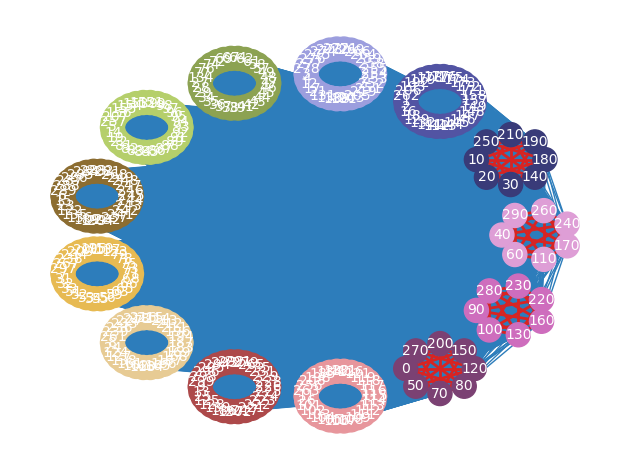

151159.8316866361

In [5]:
G = read_input('inputs/medium36.in')
solve6(G)
validate_output(G)
visualize(G)
# nx.draw(G)
score(G)

In [6]:
run_all(solve6, 'inputs', 'output')
tar('output')

  0%|          | 0/780 [00:00<?, ?it/s]

inputs/large225.in: cost 2009.6378778446226
inputs/small232.in: cost 8485.506101865805


/tmp/ipykernel_63/1899913786.py:30: RuntimeWarning: invalid value encountered in double_scalars
  new_b = ( (b ** 2) - (b_i ** 2) - (b_j ** 2) + ((b_i - (1/n)) ** 2) + ((b_j + (1/n)) ** 2) ) ** 0.5


inputs/large116.in: cost 14842.31591025766
inputs/large59.in: cost 16233.439017326278
inputs/small150.in: cost 93471.90918776828
inputs/large147.in: cost 28399.262246465125
inputs/small101.in: cost 138185.49323151432
inputs/small197.in: cost 104170.01581064695
inputs/small206.in: cost 2010.797760513179
inputs/large240.in: cost 77332.27765662927
inputs/medium7.in: cost 135050.97081429444
inputs/small257.in: cost 241314.01581064696
inputs/large180.in: cost 14842.31591025766
inputs/large211.in: cost 55569.26224646513
inputs/small135.in: cost 143166.4598828962
inputs/small68.in: cost 31172.469184168058
inputs/medium249.in: cost 2009.5536923187667
inputs/large173.in: cost 7678.815003314424
inputs/small164.in: cost 16953.870601390787
inputs/medium218.in: cost 3312.786328891362
inputs/medium189.in: cost 9150.104074763272
inputs/small39.in: cost 6581.797760513179
inputs/large122.in: cost 1219.2493960703473
inputs/medium84.in: cost 5461.205948025516
inputs/medium26.in: cost 96382.04582634693
in

inputs/medium198.in: cost 141935.6706898088
inputs/small28.in: cost 136828.14243574018
inputs/small175.in: cost 96998.49323151434
inputs/large162.in: cost 185739.90560989306
inputs/small79.in: cost 104842.31591025766
inputs/medium258.in: cost 24470.604730947358
inputs/small124.in: cost 169368.41592657613
inputs/large191.in: cost 14842.466184056517
inputs/large200.in: cost 9002.781353172539
inputs/small246.in: cost 9016.608175101966
inputs/large251.in: cost 5654.815003314424
inputs/small186.in: cost 7199.506101865805
inputs/small217.in: cost 24539.488156463463
inputs/small110.in: cost 402517.3688118974
inputs/large19.in: cost 98449.45341561103
inputs/large156.in: cost 16328.829680955545
inputs/small141.in: cost 7344.506101865805
inputs/large107.in: cost 130339.30691052646
inputs/large48.in: cost 73008.48630889005
inputs/small223.in: cost 307744.01581064693
inputs/large234.in: cost 26386.262246465125
inputs/medium49.in: cost 87669.01581064695
inputs/medium18.in: cost 19793.31591025766
in

inputs/small80.in: cost 82087.90918776828
inputs/large85.in: cost 739.905609893065
inputs/medium161.in: cost 17992.706854968754
inputs/large76.in: cost 2009.6378778446226
inputs/large139.in: cost 1219.2493960703473
inputs/medium192.in: cost 168807.08589081
inputs/small22.in: cost 12548.05701472767
inputs/medium203.in: cost 100336.60100430102
inputs/large168.in: cost 9045.781353172539
inputs/large27.in: cost 25032.262246465125
inputs/medium252.in: cost 42473.520836545176
inputs/small73.in: cost 46032.55792167091
inputs/small229.in: cost 5313.853839147427
inputs/medium155.in: cost 78768.62251857058
inputs/medium104.in: cost 771.905609893065
inputs/small47.in: cost 25471.14243574018
inputs/large13.in: cost 1219.2493960703473
inputs/medium237.in: cost 81802.65035502546
inputs/small16.in: cost 402517.3688118974
inputs/large42.in: cost 24850.262246465125
inputs/medium58.in: cost 739.905609893065
inputs/large6.in: cost 14842.31591025766
inputs/medium88.in: cost 115207.5704478249
inputs/medium

inputs/small24.in: cost 167925.01581064696
inputs/small179.in: cost 359317.3688118974
inputs/large21.in: cost 1219.2493960703473
inputs/small75.in: cost 402517.3688118974
inputs/medium254.in: cost 9003.104074763272
inputs/small128.in: cost 167101.01581064696
inputs/small6.in: cost 14864.201219078952
inputs/medium136.in: cost 3803.786328891362
inputs/small86.in: cost 14842.31591025766
inputs/large83.in: cost 449.2277266951576
inputs/medium167.in: cost 95276.09314259021
inputs/medium99.in: cost 2009.5536923187667
inputs/small133.in: cost 9404.647857241496
inputs/large175.in: cost 81410.00044834877
inputs/small162.in: cost 3313.8538391474267
inputs/large124.in: cost 26050.262246465125
inputs/small200.in: cost 138603.49323151432
inputs/small191.in: cost 77342.31591025766
inputs/large246.in: cost 5460.815003314424
inputs/large98.in: cost 8700.815003314423
inputs/medium1.in: cost 112731.16567854794
inputs/small251.in: cost 28368.77380085329
inputs/large217.in: cost 24876.262246465125
inputs/

inputs/medium159.in: cost 28952.91058001589
inputs/medium108.in: cost 119712.87934927351
inputs/large232.in: cost 5460.815003314424
inputs/small116.in: cost 9003.647857241496
inputs/large150.in: cost 25876.262246465125
inputs/small147.in: cost 76550.90918776828
inputs/large101.in: cost 16080.31591025766
inputs/large206.in: cost 3312.6121493860305
inputs/large197.in: cost 44813.00044834878
inputs/small240.in: cost 165703.01581064696
inputs/large257.in: cost 28274.262246465125
inputs/large89.in: cost 9503.781353172539
inputs/small211.in: cost 32857.64785724149
inputs/small180.in: cost 5462.506101865805
inputs/large135.in: cost 24676.262246465125
inputs/small173.in: cost 5996.506101865805
inputs/large164.in: cost 18022.31591025766
inputs/small122.in: cost 68842.31591025766
